# SARIMA
Modelo de series temporales SARIMA para predecir el tra fico
web a 6 meses. 

### Librerías

In [ ]:
import pyodbc
import pandas as pd
import numpy as np
import os
import logging
from functools import reduce
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.api import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from itertools import product

### Conexión a Azure

In [30]:
# Configura logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Configuración de conexión
AZURE_SERVER = 'uaxmathfis.database.windows.net'
AZURE_DATABASE = 'usecases'
AZURE_DRIVER = '{ODBC Driver 17 for SQL Server}'
CSV_PATH = 'datos_combinados.csv'

def get_azure_connection():
    """Establece conexión con Azure SQL usando autenticación interactiva"""
    conn_str = f"DRIVER={AZURE_DRIVER};SERVER={AZURE_SERVER};DATABASE={AZURE_DATABASE};Authentication=ActiveDirectoryInteractive"
    try:
        conn = pyodbc.connect(conn_str)
        logging.info("Conexión exitosa a Azure SQL")
        return conn
    except Exception as e:
        logging.error(f"Error de conexión: {e}")
        return None

def download_and_combine_tables():
    """Descarga todas las tablas y las combina correctamente por fecha"""
    # Eliminar el archivo CSV si existe
    if os.path.exists(CSV_PATH):
        try:
            os.remove(CSV_PATH)
            logging.info(f"Archivo existente {CSV_PATH} eliminado")
        except Exception as e:
            logging.error(f"No se pudo eliminar {CSV_PATH}: {e}")

    queries = {
        'MMM01_WEB': "SELECT * FROM DATAEX.MMM01_WEB",
        'MMM02_VISIT': "SELECT * FROM DATAEX.MMM02_VISIT",
        'MMM03_OFFLINE': "SELECT * FROM DATAEX.MMM03_OFFLINE",
        'MMM04_TIME': "SELECT * FROM DATAEX.MMM04_TIME",
        'MMM05_INV': "SELECT * FROM DATAEX.MMM05_INV"
    }

    conn = get_azure_connection()
    if not conn:
        return pd.DataFrame()

    try:
        # Descargar todas las tablas
        dfs = {}
        for name, query in queries.items():
            try:
                df = pd.read_sql(query, conn)
                if 'ID_Date' in df.columns:
                    df['ID_Date'] = pd.to_datetime(df['ID_Date'].astype(str), format=('%Y%m'))
                    df = df.drop_duplicates(subset=['ID_Date'])
                    # Agregamos el nombre de la tabla como prefijo a las columnas
                    df.columns = [f'{name}_{col}' if col != 'ID_Date' else col for col in df.columns]
                    dfs[name] = df.set_index('ID_Date')
                    logging.info(f"Tabla {name} descargada ({len(df)} registros)")
                else:
                    logging.warning(f"Tabla {name} no tiene columna ID_Date")
            except Exception as e:
                logging.error(f"Error procesando {name}: {e}")

        # Combinar horizontalmente por fecha
        if dfs:
            # Fusionar todas las tablas usando merge secuencial
            combined = reduce(lambda left, right: pd.merge(
                left, right, 
                left_index=True, right_index=True, 
                how='outer'
            ), dfs.values())
            
            # Guardar a CSV (se creará nuevo archivo)
            combined.to_csv(CSV_PATH)
            logging.info(f"Nuevo archivo {CSV_PATH} creado ({len(combined)} registros combinados)")
            return combined
        else:
            logging.warning("No se descargaron datos válidos")
            return pd.DataFrame()

    finally:
        conn.close()

def load_from_csv():
    """Carga los datos previamente guardados desde el CSV"""
    try:
        if os.path.exists(CSV_PATH):
            return pd.read_csv(CSV_PATH, parse_dates=['ID_Date'], index_col='ID_Date')
        else:
            logging.warning(f"Archivo {CSV_PATH} no encontrado")
            return pd.DataFrame()
    except Exception as e:
        logging.error(f"Error cargando CSV: {e}")
        return pd.DataFrame()

# Ejecutar la descarga (siempre creará nuevo archivo)
df = download_and_combine_tables()

# Para cargar los datos posteriormente (si el archivo existe)
# df = load_from_csv()

if not df.empty:
    print("\nDatos combinados correctamente:")
    print(f"Total de registros: {len(df)}")
    print(f"Columnas: {len(df.columns)}")
    df.head()
else:
    print("No hay datos disponibles")

2025-04-07 12:47:21,549 - INFO - Archivo existente datos_combinados.csv eliminado
2025-04-07 12:47:21,915 - INFO - Conexión exitosa a Azure SQL
C:\Users\aleja\AppData\Local\Temp\ipykernel_11480\1911041345.py:48: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)
2025-04-07 12:47:21,957 - INFO - Tabla MMM01_WEB descargada (36 registros)
C:\Users\aleja\AppData\Local\Temp\ipykernel_11480\1911041345.py:48: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)
2025-04-07 12:47:21,992 - INFO - Tabla MMM02_VISIT descargada (36 registros)
C:\Users\aleja\AppData\Local\Temp\ipykernel_11480\1911041345.py:48: UserWarning: pandas only supports 


Datos combinados correctamente:
Total de registros: 36
Columnas: 46


### DataFrame

In [31]:
df = load_from_csv()
df = df.reset_index()

df

,ID_Date,MMM01_WEB_Unique_visitors,MMM01_WEB_PDFBrochuresDownloaded,MMM01_WEB_ProductConfigurator,MMM01_WEB_Product_configurator_Visists,MMM01_WEB_SocialNetworks,MMM01_WEB_DirectTraffic,MMM01_WEB_EMail,MMM01_WEB_NaturalSearch,MMM01_WEB_OnlineMedia,...,MMM05_INV_CINE,MMM05_INV_EXTERIOR,MMM05_INV_INTERNET,MMM05_INV_PRENSA,MMM05_INV_PRODUCCION,MMM05_INV_RADIO,MMM05_INV_REVISTAS,MMM05_INV_PlataformasVideo,MMM05_INV_VARIOS,MMM05_INV_INV_Total
0,2022-01-01,272382,4838,33222,94248,1415,65373,25,167199,63649,...,59887.840,8200.00,133666.43000,0.00000,6050.00,2426.40,18013.5000,338824.940,7531.0300,5.746001e+05
1,2022-02-01,352581,5823,38570,109531,546,77209,26,176733,124861,...,72291.560,94627.51,189275.94000,10000.00000,6700.00,0.00,49110.9100,487537.140,6972.0200,9.165151e+05
2,2022-03-01,332955,4845,33956,97805,5444,83178,341,173514,104132,...,55000.000,0.00,214037.62000,4500.00000,3700.00,0.00,0.0000,75000.000,15284.8500,3.675225e+05
3,2022-04-01,282169,3711,45949,90689,1184,69335,162,162805,74044,...,10883.300,0.00,194816.97000,48800.00000,21550.00,1140.00,40876.0000,610865.890,12255.7500,9.411879e+05
4,2022-05-01,261829,9037,48685,92069,8648,70972,210,156011,44196,...,74333.200,0.00,130795.16000,11000.00000,4900.00,102851.86,20775.7500,393807.740,7926.4600,7.463902e+05
5,2022-06-01,201141,10727,38608,73421,1082,61455,2374,134355,15600,...,37400.000,0.00,67827.66000,0.00000,12250.00,5526.49,75573.1300,0.000,5405.7200,2.039830e+05
6,2022-07-01,206538,11023,38912,74564,909,66835,204,144300,11000,...,58816.500,0.00,61897.17000,0.00000,650.00,158.40,2600.0000,1500.000,4574.5000,1.301966e+05
7,2022-08-01,259903,15743,47613,88335,7511,78704,14,172986,15205,...,0.000,0.00,46362.01000,13000.00000,9750.00,345.60,33860.0000,391987.870,28716.2600,5.240217e+05
8,2022-09-01,261618,14130,44164,83840,1773,58630,199,174125,41832,...,39483.300,0.00,77470.41000,9507.80000,7850.00,2686.80,14580.0000,0.000,6645.2700,1.582236e+05
9,2022-10-01,396642,16321,53200,100262,2117,74040,874,203699,162588,...,45733.200,0.00,271750.66000,0.00000,20300.00,3162.00,117786.9700,804181.400,14421.1300,1.277335e+06


### Gráfico "Revenue"

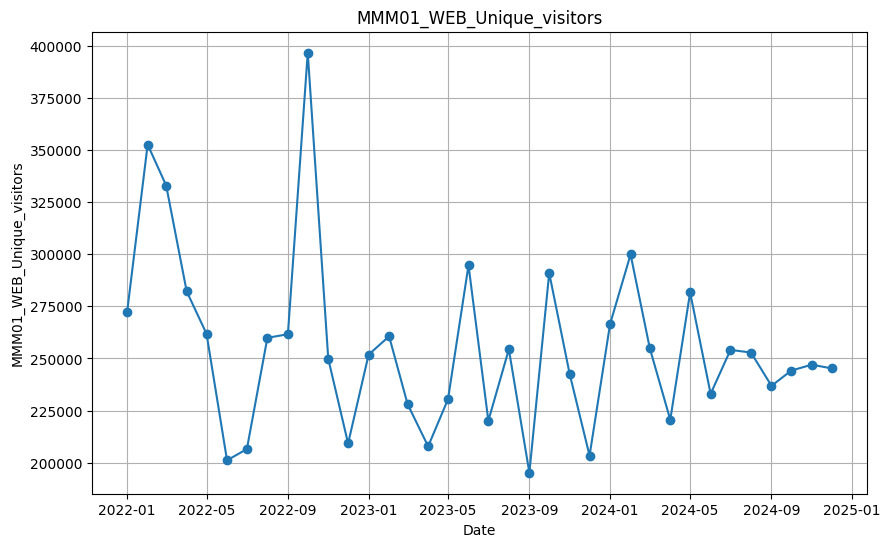

In [ ]:
# Convertir la columna 'Date' a tipo datetime y establecerla como índice
df['ID_Date'] = pd.to_datetime(df['ID_Date'], format='%d.%m.%Y')
df.set_index('ID_Date', inplace=True)

# Convertir los datos diarios a datos mensuales tomando el primer día de cada mes
df_monthly = df.resample('MS').mean().asfreq('MS')

# Filtrar todas las filas donde 'Revenue' no sea nulo o NaN
df_monthly_filtered = df_monthly.dropna(subset=['MMM01_WEB_Unique_visitors'])

# Graficar la columna 'Revenue'
plt.figure(figsize=(10, 6))
plt.plot(df_monthly_filtered.index, df_monthly_filtered['MMM01_WEB_Unique_visitors'], marker='o', linestyle='-')
plt.title('MMM01_WEB_Unique_visitors')
plt.xlabel('Date')
plt.ylabel('MMM01_WEB_Unique_visitors')
plt.grid(True)
plt.show()

### Descomposición de la serie temporal

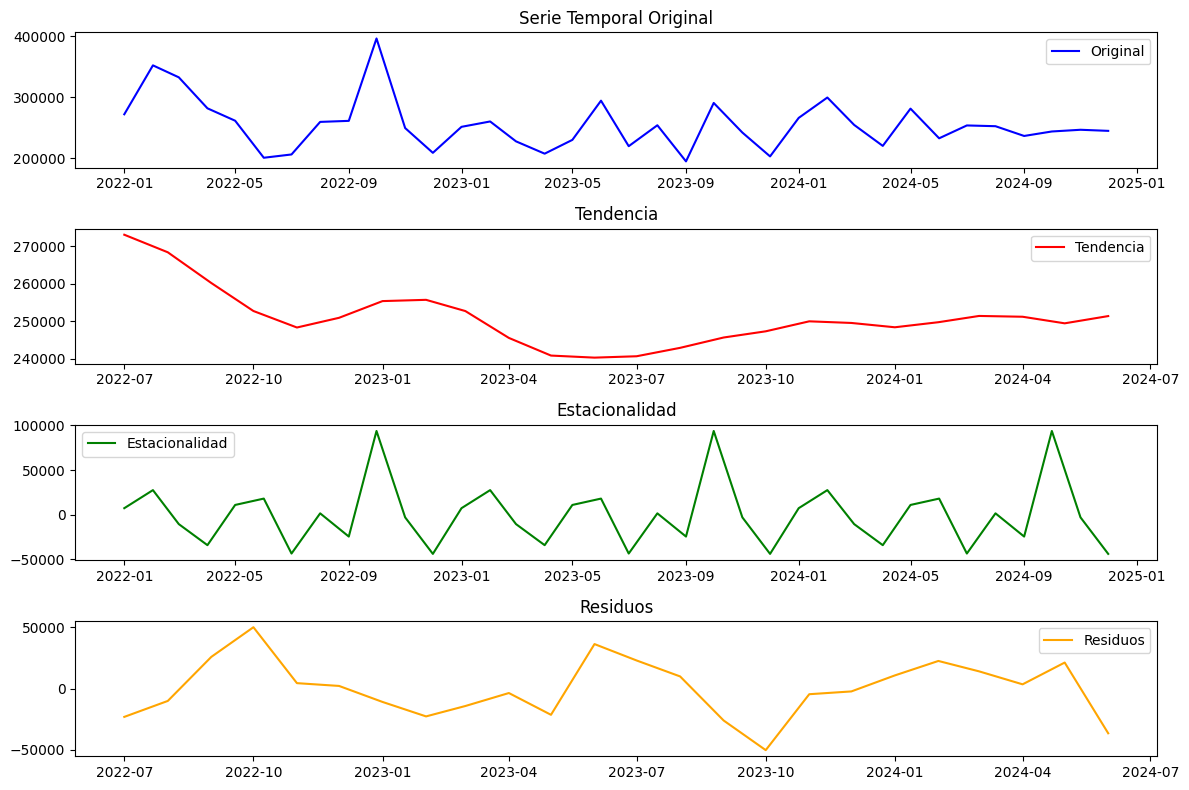

In [ ]:
# Descomposición de la serie temporal
decomposition = seasonal_decompose(df['MMM01_WEB_Unique_visitors'], model='additive')

# Obtención de las componentes
trend = decomposition.trend
seasonal = decomposition.seasonal
residuals = decomposition.resid

# Graficar las componentes
plt.figure(figsize=(12, 8))

plt.subplot(411)
plt.plot(df['MMM01_WEB_Unique_visitors'], label='Original', color='blue')
plt.legend()
plt.title('Serie Temporal Original')

plt.subplot(412)
plt.plot(trend, label='Tendencia', color='red')
plt.legend()
plt.title('Tendencia')

plt.subplot(413)
plt.plot(seasonal, label='Estacionalidad', color='green')
plt.legend()
plt.title('Estacionalidad')

plt.subplot(414)
plt.plot(residuals, label='Residuos', color='orange')
plt.legend()
plt.title('Residuos')

plt.tight_layout()
plt.show()

### División train y test

In [34]:
# DIVISIÓN DE DATOS CON SOLAPAMIENTO
total_length = len(df_monthly_filtered)
train_size = int(total_length * 0.80)
overlap_size = max(1, int(total_length * 0.03))  # Mínimo 1 punto de solapamiento
test_size = int(total_length * 0.20)  # 20% para test

# Ajustar tamaños
test_size = min(test_size, total_length - train_size + overlap_size)

# Definir conjuntos
train = df_monthly_filtered.iloc[:train_size]
test = df_monthly_filtered.iloc[train_size - overlap_size : train_size + test_size - overlap_size]

### Combinaciones para encontrar el mejor modelo

c:\Users\aleja\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\aleja\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\aleja\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\aleja\AppData\Local

Top 5 Modelos SARIMA basados en AIC:
       order seasonal_order         aic         bic          rmse        r2
0  (1, 2, 2)  (0, 1, 1, 12)  348.804724  352.000011  58163.585358 -9.366225
1  (1, 2, 2)  (1, 1, 0, 12)  349.884806  353.080092  58725.123755 -9.567352
2  (0, 2, 2)  (0, 1, 1, 12)  349.917446  352.473676  48067.367645 -6.079767
3  (0, 2, 1)  (0, 1, 1, 12)  350.468198  352.385370  45021.257319 -5.210886
4  (0, 2, 2)  (1, 1, 0, 12)  350.553361  353.109590  48658.074203 -6.254845


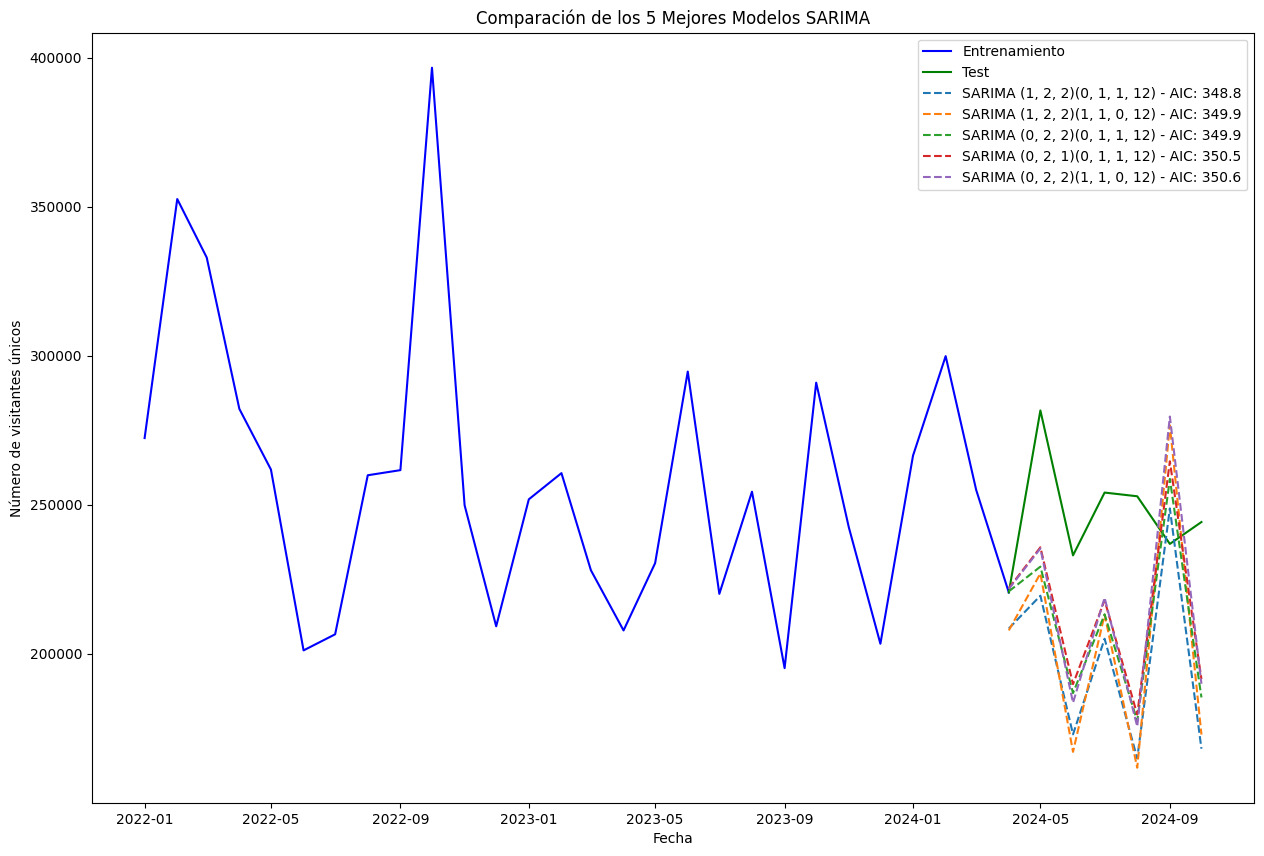


Modelo 1: SARIMA(1, 2, 2)(0, 1, 1, 12)
                                      SARIMAX Results                                       
Dep. Variable:            MMM01_WEB_Unique_visitors   No. Observations:                   28
Model:             SARIMAX(1, 2, 2)x(0, 1, [1], 12)   Log Likelihood                -169.402
Date:                             lu., 07 abr. 2025   AIC                            348.805
Time:                                      12:47:48   BIC                            352.000
Sample:                                  01-01-2022   HQIC                           348.509
                                       - 04-01-2024                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9488      0.740     -1.282      0.200    

In [ ]:
# Función para calcular métricas
def calcular_metricas(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    return mse, mae, rmse, r2

# Función para evaluar modelo SARIMA
def evaluar_sarima(train_data, test_data, order, seasonal_order):
    try:
        # Ajustar el modelo
        model = SARIMAX(train_data, order=order, seasonal_order=seasonal_order)
        model_fit = model.fit(disp=False)
        
        # Predecir
        predictions = model_fit.get_prediction(start=len(train_data), 
                                              end=len(train_data) + len(test_data) - 1)
        pred_mean = predictions.predicted_mean
        
        # Calcular métricas
        metrics = calcular_metricas(test_data, pred_mean)
        
        return {
            'order': order,
            'seasonal_order': seasonal_order,
            'aic': model_fit.aic,
            'bic': model_fit.bic,
            'mse': metrics[0],
            'mae': metrics[1],
            'rmse': metrics[2],
            'r2': metrics[3],
            'model': model_fit
        }
    except:
        return None

# Rangos de parámetros a probar
p = d = q = range(0, 3)  # Parámetros no estacionales
P = D = Q = range(0, 2)  # Parámetros estacionales
m = 12  # Estacionalidad mensual (12 meses)

# Generar todas las combinaciones posibles
param_combinations = list(product(p, d, q, P, D, Q))

results = []

# Probar cada combinación de parámetros
for params in param_combinations:
    order = (params[0], params[1], params[2])
    seasonal_order = (params[3], params[4], params[5], m)
    
    # Evaluar el modelo
    result = evaluar_sarima(train['MMM01_WEB_Unique_visitors'], 
                           test['MMM01_WEB_Unique_visitors'], 
                           order, seasonal_order)
    
    if result is not None:
        results.append(result)

# Convertir a DataFrame y ordenar por AIC (mejores modelos primero)
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by='aic').reset_index(drop=True)

# Seleccionar los 5 mejores modelos
top_5_models = results_df.head(5)

# Mostrar los 5 mejores modelos
print("Top 5 Modelos SARIMA basados en AIC:")
print(top_5_models[['order', 'seasonal_order', 'aic', 'bic', 'rmse', 'r2']])

# Graficar las predicciones de los mejores modelos
plt.figure(figsize=(15, 10))
plt.plot(train.index, train['MMM01_WEB_Unique_visitors'], label='Entrenamiento', color='blue')
plt.plot(test.index, test['MMM01_WEB_Unique_visitors'], label='Test', color='green')

for i, model_info in top_5_models.iterrows():
    predictions = model_info['model'].get_prediction(
        start=len(train), 
        end=len(train) + len(test) - 1
    ).predicted_mean
    
    plt.plot(test.index, predictions, 
             label=f'SARIMA {model_info["order"]}{model_info["seasonal_order"]} - AIC: {model_info["aic"]:.1f}',
             linestyle='--')

plt.xlabel('Fecha')
plt.ylabel('Número de visitantes únicos')
plt.title('Comparación de los 5 Mejores Modelos SARIMA')
plt.legend()
plt.show()

# Función para graficar residuos
def plot_residuals(test_data, predictions, title):
    residuals = test_data - predictions
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Gráfico de series temporales de residuos
    axes[0].plot(test_data.index, residuals)
    axes[0].axhline(y=0, color='r', linestyle='--')
    axes[0].set_title(f'Residuos - {title}')
    axes[0].set_xlabel('Fecha')
    axes[0].set_ylabel('Residuos')
    
    # Histograma de residuos
    axes[1].hist(residuals, bins=20)
    axes[1].set_title(f'Distribución de Residuos - {title}')
    axes[1].set_xlabel('Residuos')
    axes[1].set_ylabel('Frecuencia')
    
    plt.tight_layout()
    plt.show()


# Mostrar resumen de los mejores modelos
for i, model_info in top_5_models.iterrows():
    print(f"\nModelo {i+1}: SARIMA{model_info['order']}{model_info['seasonal_order']}")
    print("="*60)
    print(model_info['model'].summary())
    print("\nMétricas:")
    print(f"AIC: {model_info['aic']:.2f}")
    print(f"BIC: {model_info['bic']:.2f}")
    print(f"RMSE: {model_info['rmse']:.2f}")
    print(f"R²: {model_info['r2']:.2f}") 

## Modelo SARIMA I

c:\Users\aleja\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\aleja\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


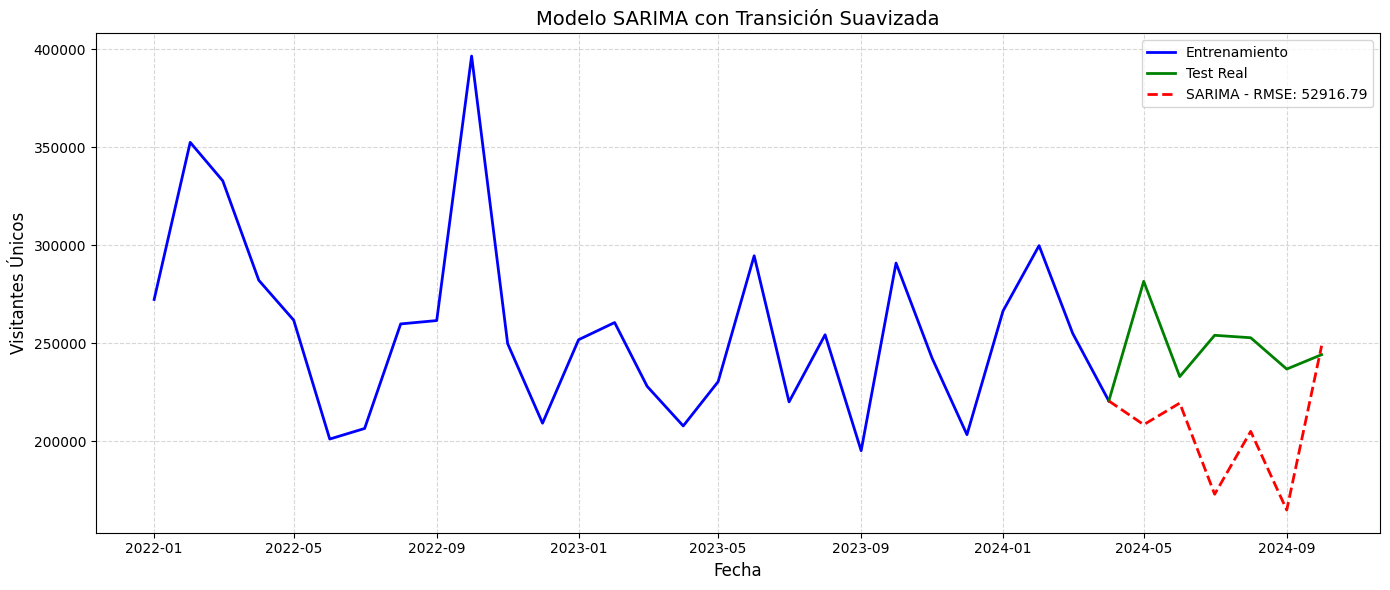

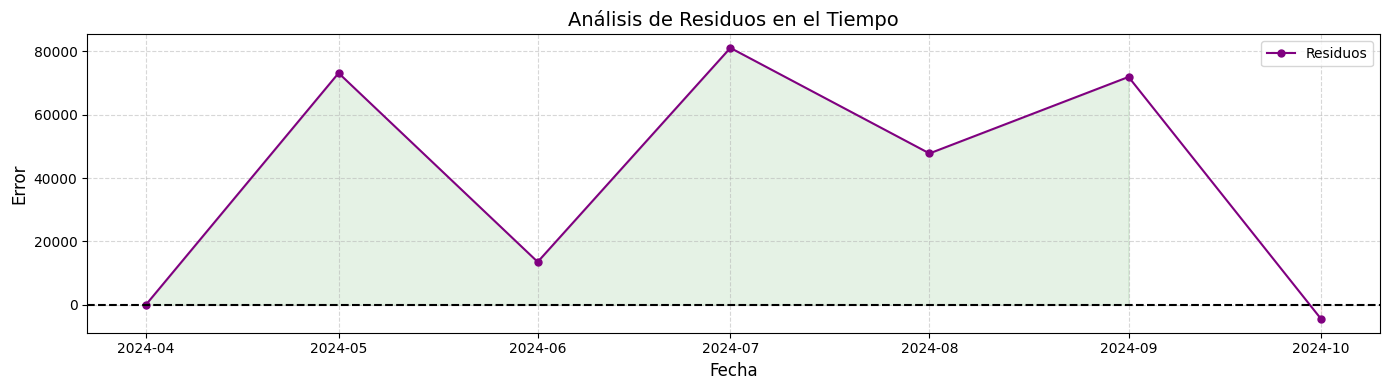

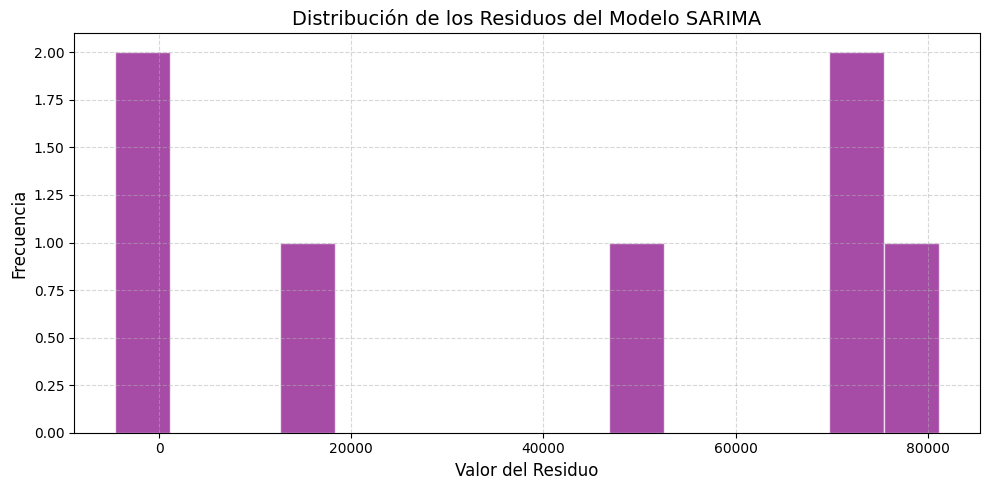


TABLA DE RESIDUOS DETALLADA:
     Fecha  Valor Real  Predicción  Residuo  Error Absoluto  Error %
2024-04-01    220584.0   220584.00     0.00            0.00     0.00
2024-05-01    281652.0   208476.52 73175.48        73175.48    25.98
2024-06-01    233019.0   219491.04 13527.96        13527.96     5.81
2024-07-01    254096.0   172970.26 81125.74        81125.74    31.93
2024-08-01    252850.0   205057.19 47792.81        47792.81    18.90
2024-09-01    236865.0   164911.17 71953.83        71953.83    30.38
2024-10-01    244208.0   248763.78 -4555.78         4555.78     1.87

                REPORTE COMPLETO DEL MODELO                 

>>> ESTADÍSTICAS DEL MODELO SARIMA:
                                      SARIMAX Results                                       
Dep. Variable:            MMM01_WEB_Unique_visitors   No. Observations:                   28
Model:             SARIMAX(1, 2, 2)x(0, 1, [1], 12)   Log Likelihood                -169.402
Date:                             lu., 0

In [36]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.api import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# 1. DIVISIÓN DE DATOS CON SOLAPAMIENTO
total_length = len(df_monthly_filtered)
train_size = int(total_length * 0.80)
overlap_size = max(1, int(total_length * 0.03))  # Mínimo 1 punto de solapamiento
test_size = int(total_length * 0.20)  # 20% para test

# Ajustar tamaños
test_size = min(test_size, total_length - train_size + overlap_size)

# Definir conjuntos
train = df_monthly_filtered.iloc[:train_size]
test = df_monthly_filtered.iloc[train_size - overlap_size : train_size + test_size - overlap_size]

# 2. MODELO SARIMA
sarima_model = SARIMAX(train['MMM01_WEB_Unique_visitors'], 
                      order=(1, 2, 2), 
                      seasonal_order=(0, 1, 1, 12))
sarima_fit = sarima_model.fit(disp=False)

# 3. PREDICCIÓN (comenzando desde el solapamiento)
start_idx = train_size - overlap_size
end_idx = start_idx + len(test) - 1

sarima_predictions = sarima_fit.get_prediction(
    start=df_monthly_filtered.index[start_idx],
    end=df_monthly_filtered.index[end_idx]
).predicted_mean

# Ajustar primer punto para conexión suave
sarima_predictions.iloc[0] = train['MMM01_WEB_Unique_visitors'].iloc[-1]

# 4. CÁLCULO DE MÉTRICAS
def calcular_metricas(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return {'MSE': mse, 'MAE': mae, 'RMSE': rmse, 'R²': r2, 'MAPE': mape}

metrics = calcular_metricas(test['MMM01_WEB_Unique_visitors'], sarima_predictions)

# 5. GRÁFICO PRINCIPAL
plt.figure(figsize=(14, 6))

# Series temporales
plt.plot(train.index, train['MMM01_WEB_Unique_visitors'], label='Entrenamiento', color='blue', linewidth=2)
plt.plot(test.index, test['MMM01_WEB_Unique_visitors'], label='Test Real', color='green', linewidth=2)
plt.plot(test.index, sarima_predictions, '--', label=f'SARIMA - RMSE: {metrics["RMSE"]:.2f}', color='red', linewidth=2)

# Línea de conexión
plt.plot([train.index[-1], test.index[0]], 
         [train['MMM01_WEB_Unique_visitors'].iloc[-1], sarima_predictions.iloc[0]], 
         '--', color='red', alpha=0.5)

plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Visitantes Únicos', fontsize=12)
plt.title('Modelo SARIMA con Transición Suavizada', fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# 6. ANÁLISIS DE RESIDUOS
residuos = test['MMM01_WEB_Unique_visitors'] - sarima_predictions

# Gráfico de residuos en el tiempo
plt.figure(figsize=(14, 4))
plt.plot(test.index, residuos, 'o-', color='purple', label='Residuos', markersize=5)
plt.axhline(0, color='black', linestyle='--')
plt.fill_between(test.index, residuos, 0, where=(residuos>=0), color='green', alpha=0.1)
plt.fill_between(test.index, residuos, 0, where=(residuos<=0), color='red', alpha=0.1)
plt.title('Análisis de Residuos en el Tiempo', fontsize=14)
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Error', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# 7. DISTRIBUCIÓN DE RESIDUOS
plt.figure(figsize=(10, 5))
plt.hist(residuos, bins=15, color='purple', edgecolor='white', alpha=0.7)
plt.title('Distribución de los Residuos del Modelo SARIMA', fontsize=14)
plt.xlabel('Valor del Residuo', fontsize=12)
plt.ylabel('Frecuencia', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# 8. TABLA DE RESIDUOS DETALLADA
residuals_df = pd.DataFrame({
    'Fecha': test.index,
    'Valor Real': test['MMM01_WEB_Unique_visitors'],
    'Predicción': sarima_predictions,
    'Residuo': residuos,
    'Error Absoluto': np.abs(residuos),
    'Error %': (np.abs(residuos)/test['MMM01_WEB_Unique_visitors'])*100
}).round(2)

print("\nTABLA DE RESIDUOS DETALLADA:")
print(residuals_df.to_string(index=False))

# 9. REPORTE ESTADÍSTICO
print("\n" + "="*60)
print("REPORTE COMPLETO DEL MODELO".center(60))
print("="*60)

print("\n>>> ESTADÍSTICAS DEL MODELO SARIMA:")
print(sarima_fit.summary())

print("\n>>> MÉTRICAS DE PRECISIÓN:")
print(f"MSE:  {metrics['MSE']:.4f}")
print(f"MAE:  {metrics['MAE']:.4f}")
print(f"RMSE: {metrics['RMSE']:.4f}")
print(f"R²:   {metrics['R²']:.4f}")
print(f"MAPE: {metrics['MAPE']:.2f}%")

print("\n>>> RESUMEN DE ERRORES:")
print(residuals_df[['Error Absoluto', 'Error %']].describe().round(2))

## Modelo SARIMA II

c:\Users\aleja\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


Métricas del Modelo SARIMA (0, 2, 2)(1, 1, 0, 12): (2248243428.889901, 40207.316980989024, 47415.6454020179, -6.871199760532034)


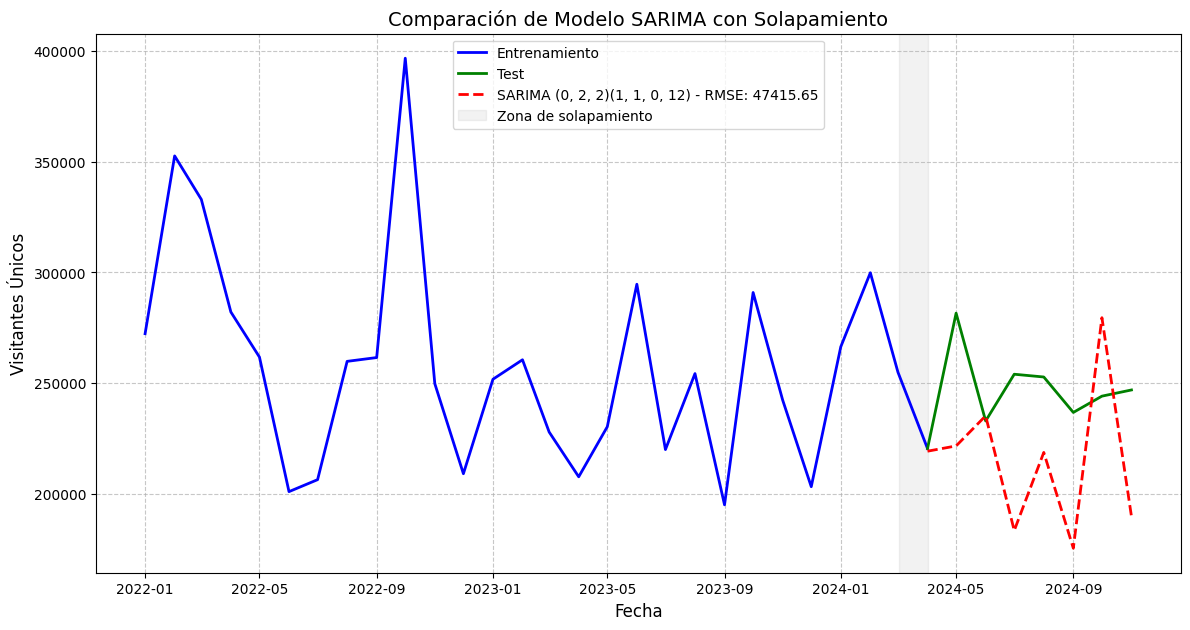


Estadísticas del Modelo SARIMA:
AIC: 350.55 | BIC: 353.11
                                      SARIMAX Results                                      
Dep. Variable:           MMM01_WEB_Unique_visitors   No. Observations:                   28
Model:             SARIMAX(0, 2, 2)x(1, 1, [], 12)   Log Likelihood                -171.277
Date:                            lu., 07 abr. 2025   AIC                            350.553
Time:                                     12:47:49   BIC                            353.110
Sample:                                 01-01-2022   HQIC                           350.317
                                      - 04-01-2024                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.0900      0.748     -1.458    

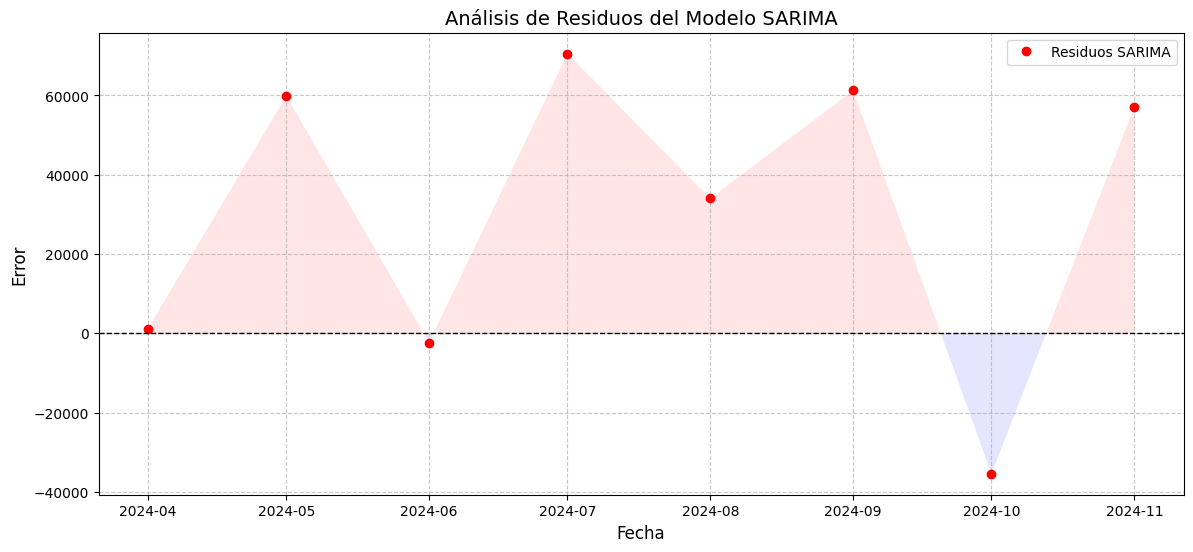

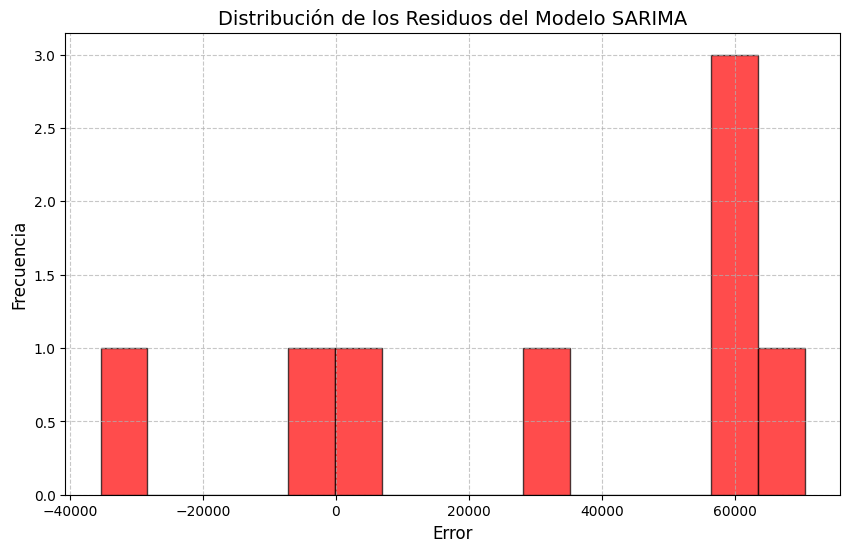


Tabla de Residuos Detallada:
                Fecha  Valor Real  Predicción   Residuo  Error Absoluto
2024-04-01 2024-04-01    220584.0   219378.95   1205.05         1205.05
2024-05-01 2024-05-01    281652.0   221756.47  59895.53        59895.53
2024-06-01 2024-06-01    233019.0   235321.85  -2302.85         2302.85
2024-07-01 2024-07-01    254096.0   183569.71  70526.29        70526.29
2024-08-01 2024-08-01    252850.0   218820.30  34029.70        34029.70
2024-09-01 2024-09-01    236865.0   175613.29  61251.71        61251.71
2024-10-01 2024-10-01    244208.0   279598.73 -35390.73        35390.73
2024-11-01 2024-11-01    247005.0   189948.32  57056.68        57056.68


In [ ]:
# Ajustar modelo SARIMA
sarima_model2 = SARIMAX(train['MMM01_WEB_Unique_visitors'], 
                       order=(0, 2, 2), 
                       seasonal_order=(1, 1, 0, 12))
sarima_fit2 = sarima_model2.fit()

# Predecir EXACTAMENTE sobre el rango de test
sarima_predictions2 = sarima_fit2.predict(
    start=test.index[0],
    end=test.index[-1],
    typ='levels'
)

# Función para calcular métricas
def calcular_metricas(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    return mse, mae, rmse, r2

# Calcular métricas
sarima_metrics2 = calcular_metricas(test['MMM01_WEB_Unique_visitors'], sarima_predictions2)

# Imprimir métricas
print("Métricas del Modelo SARIMA (0, 2, 2)(1, 1, 0, 12):", sarima_metrics2)

# Graficar resultados con solapamiento
plt.figure(figsize=(14, 7))
plt.plot(train.index, train['MMM01_WEB_Unique_visitors'], label='Entrenamiento', color='blue', linewidth=2)
plt.plot(test.index, test['MMM01_WEB_Unique_visitors'], label='Test', color='green', linewidth=2)
plt.plot(test.index, sarima_predictions2, 
         label=f'SARIMA (0, 2, 2)(1, 1, 0, 12) - RMSE: {sarima_metrics2[2]:.2f}', 
         linestyle='--', color='red', linewidth=2)

# Marcar zona de solapamiento
overlap_start = train.index[-1] - pd.Timedelta(days=overlap_size*30)  # Aprox. meses solapados
plt.axvspan(overlap_start, train.index[-1], alpha=0.1, color='gray', label='Zona de solapamiento')

plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Visitantes Únicos', fontsize=12)
plt.title('Comparación de Modelo SARIMA con Solapamiento', fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# Imprimir estadísticas del modelo
print("\nEstadísticas del Modelo SARIMA:")
print(f"AIC: {sarima_fit2.aic:.2f} | BIC: {sarima_fit2.bic:.2f}")
print(sarima_fit2.summary())

# Análisis de residuos
sarima_residuals2 = test['MMM01_WEB_Unique_visitors'] - sarima_predictions2

# Gráfico de residuos
plt.figure(figsize=(14, 6))
plt.plot(test.index, sarima_residuals2, label='Residuos SARIMA', color='red', marker='o', linestyle='')
plt.axhline(y=0, color='black', linestyle='--', linewidth=1)
plt.fill_between(test.index, sarima_residuals2, 0, where=(sarima_residuals2 >= 0), 
                 facecolor='red', alpha=0.1, interpolate=True)
plt.fill_between(test.index, sarima_residuals2, 0, where=(sarima_residuals2 <= 0), 
                 facecolor='blue', alpha=0.1, interpolate=True)
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Error', fontsize=12)
plt.title('Análisis de Residuos del Modelo SARIMA', fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# Histograma de residuos
plt.figure(figsize=(10, 6))
plt.hist(sarima_residuals2, bins=15, color='red', alpha=0.7, edgecolor='black')
plt.xlabel('Error', fontsize=12)
plt.ylabel('Frecuencia', fontsize=12)
plt.title('Distribución de los Residuos del Modelo SARIMA', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# DataFrame de residuos
residuals_df = pd.DataFrame({
    'Fecha': test.index,
    'Valor Real': test['MMM01_WEB_Unique_visitors'],
    'Predicción': sarima_predictions2,
    'Residuo': sarima_residuals2,
    'Error Absoluto': np.abs(sarima_residuals2)
})

print("\nTabla de Residuos Detallada:")
print(residuals_df.round(2))

## Predicción a 6 meses

c:\Users\aleja\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\aleja\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\aleja\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


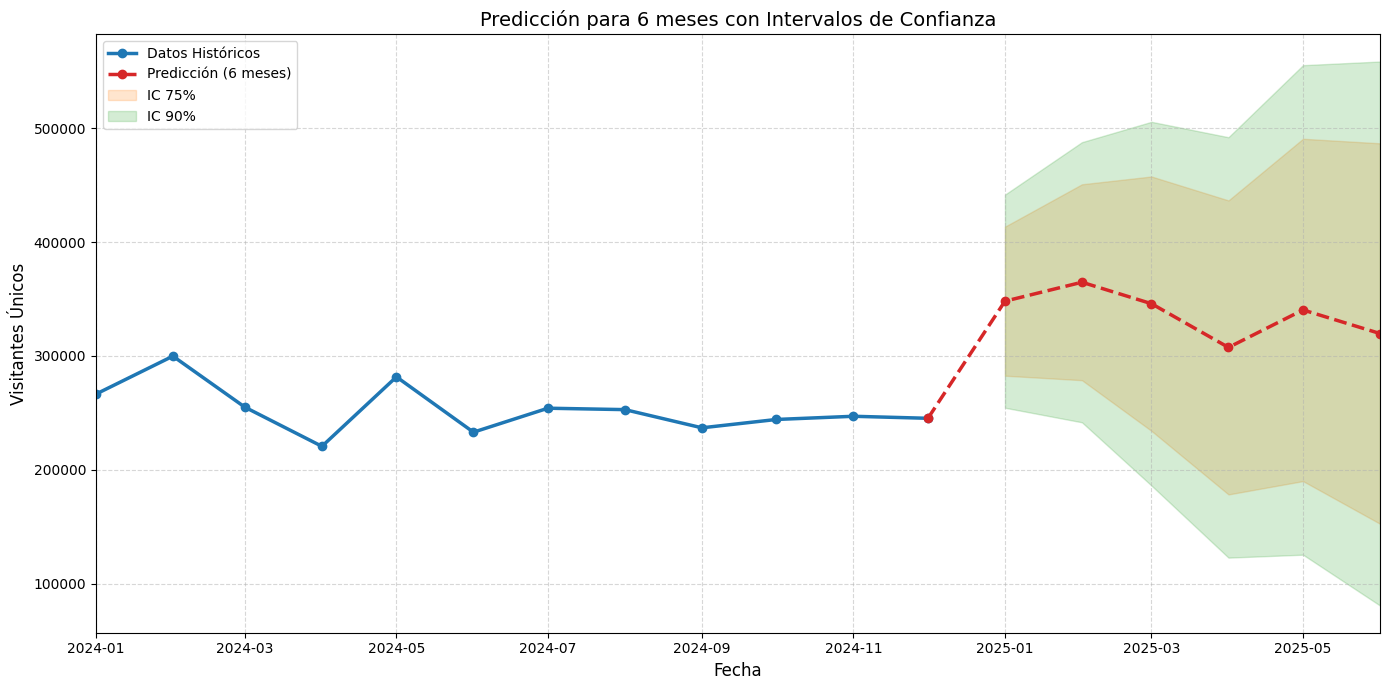


DETALLE DE PREDICCIONES:
     Fecha  Predicción  IC 75% Inferior  IC 75% Superior  IC 90% Inferior  IC 90% Superior
2025-01-01    348174.0         282670.0         413677.0         254512.0         441836.0
2025-02-01    364831.0         278725.0         450937.0         241711.0         487952.0
2025-03-01    345967.0         234158.0         457775.0         186095.0         505838.0
2025-04-01    307524.0         178300.0         436748.0         122750.0         492298.0
2025-05-01    340483.0         190020.0         490946.0         125340.0         555626.0
2025-06-01    319743.0         152534.0         486953.0          80655.0         558832.0


In [48]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.api import SARIMAX
import numpy as np

# 1. Ajustar el modelo SARIMA
sarima_model = SARIMAX(df['MMM01_WEB_Unique_visitors'], 
                      order=(1, 2, 2), 
                      seasonal_order=(0, 1, 1, 12))
sarima_fit = sarima_model.fit(disp=False)

# 2. Configurar predicción de 6 meses
forecast_months = 6
last_date = df.index[-1]

# Obtener predicción con intervalos
forecast = sarima_fit.get_forecast(steps=forecast_months)
predictions = forecast.predicted_mean
conf_75 = forecast.conf_int(alpha=0.25)  # 75% confianza
conf_90 = forecast.conf_int(alpha=0.10)  # 90% confianza

# 3. Preparar datos para gráfico (últimos 12 meses históricos)
show_last = 12
historical_data = df['MMM01_WEB_Unique_visitors'].iloc[-show_last:]

# 4. Gráfico mejorado con conexión perfecta (usando pd.concat en lugar de append)
plt.figure(figsize=(14, 7))

# Datos históricos
plt.plot(historical_data.index, historical_data, 
         label='Datos Históricos', 
         color='#1f77b4', 
         linewidth=2.5,
         marker='o')

# Crear serie extendida usando pd.concat (corrección del error)
last_point = pd.Series([historical_data.iloc[-1]], index=[historical_data.index[-1]])
extended_predictions = pd.concat([last_point, predictions])

# Predicciones
plt.plot(extended_predictions.index, extended_predictions, 
         label=f'Predicción ({forecast_months} meses)',
         color='#d62728', 
         linestyle='--', 
         linewidth=2.5,
         marker='o')

# Intervalos de confianza extendidos
conf_75_ext = pd.concat([
    pd.DataFrame([[np.nan, np.nan]], columns=conf_75.columns, index=[historical_data.index[-1]]),
    conf_75
])
conf_90_ext = pd.concat([
    pd.DataFrame([[np.nan, np.nan]], columns=conf_90.columns, index=[historical_data.index[-1]]),
    conf_90
])

plt.fill_between(conf_75_ext.index, 
                 conf_75_ext.iloc[:, 0], 
                 conf_75_ext.iloc[:, 1], 
                 color='#ff7f0e', 
                 alpha=0.2, 
                 label='IC 75%')

plt.fill_between(conf_90_ext.index, 
                 conf_90_ext.iloc[:, 0], 
                 conf_90_ext.iloc[:, 1], 
                 color='#2ca02c', 
                 alpha=0.2, 
                 label='IC 90%')

# Personalización del gráfico
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Visitantes Únicos', fontsize=12)
plt.title(f'Predicción para {forecast_months} meses con Intervalos de Confianza', fontsize=14)
plt.legend(fontsize=10, loc='upper left')
plt.grid(True, linestyle='--', alpha=0.5)

# Ajustar límites del eje x
plt.xlim(historical_data.index[0], predictions.index[-1])

plt.tight_layout()
plt.show()

# 5. Tabla de resultados
results_df = pd.DataFrame({
    'Fecha': predictions.index,
    'Predicción': predictions.round(0),
    'IC 75% Inferior': conf_75.iloc[:, 0].round(0),
    'IC 75% Superior': conf_75.iloc[:, 1].round(0),
    'IC 90% Inferior': conf_90.iloc[:, 0].round(0),
    'IC 90% Superior': conf_90.iloc[:, 1].round(0)
})

print("\nDETALLE DE PREDICCIONES:")
print(results_df.to_string(index=False))

c:\Users\aleja\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\aleja\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\aleja\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


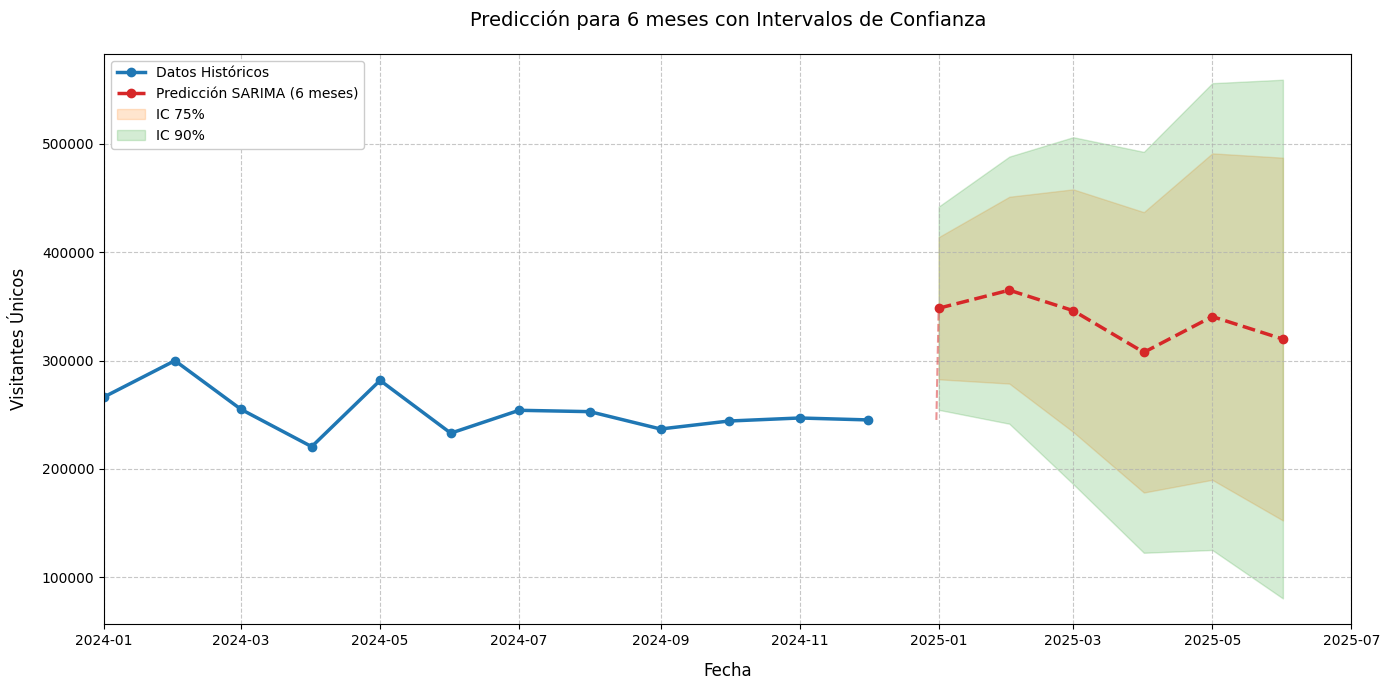


TABLA DE PREDICCIÓN PARA LOS PRÓXIMOS 6 MESES:
     Fecha  Predicción  Límite Inferior (75%)  Límite Superior (75%)  Límite Inferior (90%)  Límite Superior (90%)
2025-01-01    348174.0               282670.0               413677.0               254512.0               441836.0
2025-02-01    364831.0               278725.0               450937.0               241711.0               487952.0
2025-03-01    345967.0               234158.0               457775.0               186095.0               505838.0
2025-04-01    307524.0               178300.0               436748.0               122750.0               492298.0
2025-05-01    340483.0               190020.0               490946.0               125340.0               555626.0
2025-06-01    319743.0               152534.0               486953.0                80655.0               558832.0


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.api import SARIMAX
import numpy as np

# 1. Ajustar el modelo SARIMA a todos los datos
sarima_model = SARIMAX(df['MMM01_WEB_Unique_visitors'], 
                      order=(1, 2, 2), 
                      seasonal_order=(0, 1, 1, 12))
sarima_fit = sarima_model.fit(disp=False)

# 2. Realizar la predicción de los próximos 6 meses
forecast_months = 6
last_date = df.index[-1]
start_date = last_date + pd.DateOffset(months=1)
end_date = start_date + pd.DateOffset(months=forecast_months-1)

# Obtener predicción e intervalos de confianza
forecast = sarima_fit.get_forecast(steps=forecast_months)
sarima_predictions = forecast.predicted_mean
confidence_75 = forecast.conf_int(alpha=0.25)  # 75% de confianza
confidence_90 = forecast.conf_int(alpha=0.10)  # 90% de confianza

# 3. Preparar datos para gráfico (últimos 12 meses + predicción)
show_last = 12  # Mostrar últimos 12 meses históricos
plot_data = df['MMM01_WEB_Unique_visitors'].iloc[-show_last:]

# 4. Gráfico profesional con conexión suave
plt.figure(figsize=(14, 7))

# Datos históricos
plt.plot(plot_data.index, plot_data, 
         label='Datos Históricos', 
         color='#1f77b4', 
         linewidth=2.5,
         marker='o')

# Predicciones
pred_line, = plt.plot(sarima_predictions.index, sarima_predictions, 
                     label=f'Predicción SARIMA ({forecast_months} meses)', 
                     color='#d62728', 
                     linestyle='--', 
                     linewidth=2.5,
                     marker='o')

# Conexión entre último dato real y primera predicción
connection_date = pd.date_range(end=start_date, periods=2)
plt.plot(connection_date, 
         [plot_data.iloc[-1], sarima_predictions.iloc[0]], 
         color='#d62728', 
         linestyle='--', 
         alpha=0.5)

# Intervalos de confianza
plt.fill_between(sarima_predictions.index, 
                 confidence_75.iloc[:, 0], 
                 confidence_75.iloc[:, 1], 
                 color='#ff7f0e', 
                 alpha=0.2, 
                 label='IC 75%')

plt.fill_between(sarima_predictions.index, 
                 confidence_90.iloc[:, 0], 
                 confidence_90.iloc[:, 1], 
                 color='#2ca02c', 
                 alpha=0.2, 
                 label='IC 90%')

# Personalización del gráfico
plt.xlabel('Fecha', fontsize=12, labelpad=10)
plt.ylabel('Visitantes Únicos', fontsize=12, labelpad=10)
plt.title(f'Predicción para {forecast_months} meses con Intervalos de Confianza', fontsize=14, pad=20)
plt.legend(fontsize=10, framealpha=1)
plt.grid(True, linestyle='--', alpha=0.7)

# Ajustar los límites del eje x para mejor visualización
x_min = plot_data.index[0]
x_max = sarima_predictions.index[-1] + pd.DateOffset(months=1)
plt.xlim(x_min, x_max)

plt.tight_layout()
plt.show()

# 5. Mostrar tabla de predicciones
predictions_df = pd.DataFrame({
    'Fecha': sarima_predictions.index,
    'Predicción': sarima_predictions.round(0),
    'Límite Inferior (75%)': confidence_75.iloc[:, 0].round(0),
    'Límite Superior (75%)': confidence_75.iloc[:, 1].round(0),
    'Límite Inferior (90%)': confidence_90.iloc[:, 0].round(0),
    'Límite Superior (90%)': confidence_90.iloc[:, 1].round(0)
})

print("\nTABLA DE PREDICCIÓN PARA LOS PRÓXIMOS 6 MESES:")
print(predictions_df.to_string(index=False))

c:\Users\aleja\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\aleja\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\aleja\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


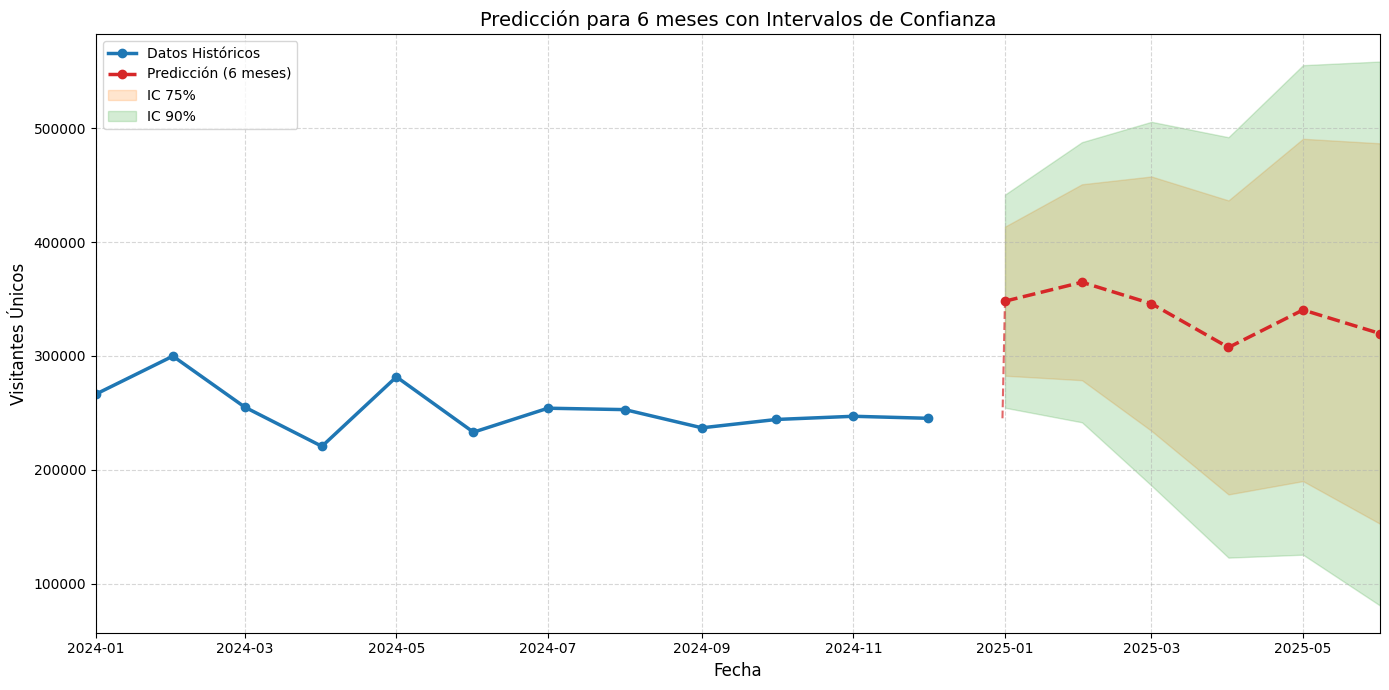


DETALLE DE PREDICCIONES:
     Fecha  Predicción  IC 75% Inferior  IC 75% Superior  IC 90% Inferior  IC 90% Superior
2025-01-01    348174.0         282670.0         413677.0         254512.0         441836.0
2025-02-01    364831.0         278725.0         450937.0         241711.0         487952.0
2025-03-01    345967.0         234158.0         457775.0         186095.0         505838.0
2025-04-01    307524.0         178300.0         436748.0         122750.0         492298.0
2025-05-01    340483.0         190020.0         490946.0         125340.0         555626.0
2025-06-01    319743.0         152534.0         486953.0          80655.0         558832.0


In [49]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.api import SARIMAX
import numpy as np

# 1. Ajustar el modelo SARIMA
sarima_model = SARIMAX(df['MMM01_WEB_Unique_visitors'], 
                      order=(1, 2, 2), 
                      seasonal_order=(0, 1, 1, 12))
sarima_fit = sarima_model.fit(disp=False)

# 2. Configurar predicción de 6 meses
forecast_months = 6
last_date = df.index[-1]

# Generar fechas de predicción correctamente alineadas
prediction_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=forecast_months, freq='MS')

# Obtener predicción con intervalos
forecast = sarima_fit.get_forecast(steps=forecast_months)
predictions = pd.Series(forecast.predicted_mean.values, index=prediction_dates)
conf_75 = pd.DataFrame(forecast.conf_int(alpha=0.25).values, index=prediction_dates, columns=['lower', 'upper'])
conf_90 = pd.DataFrame(forecast.conf_int(alpha=0.10).values, index=prediction_dates, columns=['lower', 'upper'])

# 3. Preparar datos para gráfico (últimos 12 meses históricos)
show_last = 12
historical_data = df['MMM01_WEB_Unique_visitors'].iloc[-show_last:]

# 4. Gráfico con conexión perfecta entre meses
plt.figure(figsize=(14, 7))

# Datos históricos
plt.plot(historical_data.index, historical_data, 
         label='Datos Históricos', 
         color='#1f77b4', 
         linewidth=2.5,
         marker='o')

# Conexión entre último dato y primera predicción
connection_date = pd.date_range(end=prediction_dates[0], periods=2)
plt.plot(connection_date, 
         [historical_data.iloc[-1], predictions.iloc[0]], 
         color='#d62728', 
         linestyle='--', 
         alpha=0.7)

# Predicciones
plt.plot(predictions.index, predictions, 
         label=f'Predicción ({forecast_months} meses)',
         color='#d62728', 
         linestyle='--', 
         linewidth=2.5,
         marker='o')

# Intervalos de confianza
plt.fill_between(predictions.index, 
                 conf_75['lower'], 
                 conf_75['upper'], 
                 color='#ff7f0e', 
                 alpha=0.2, 
                 label='IC 75%')

plt.fill_between(predictions.index, 
                 conf_90['lower'], 
                 conf_90['upper'], 
                 color='#2ca02c', 
                 alpha=0.2, 
                 label='IC 90%')

# Personalización del gráfico
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Visitantes Únicos', fontsize=12)
plt.title(f'Predicción para {forecast_months} meses con Intervalos de Confianza', fontsize=14)
plt.legend(fontsize=10, loc='upper left')
plt.grid(True, linestyle='--', alpha=0.5)

# Ajustar límites del eje x para mostrar transición
plt.xlim(historical_data.index[0], predictions.index[-1])

plt.tight_layout()
plt.show()

# 5. Tabla de resultados
results_df = pd.DataFrame({
    'Fecha': predictions.index.strftime('%Y-%m-%d'),
    'Predicción': predictions.round(0),
    'IC 75% Inferior': conf_75['lower'].round(0),
    'IC 75% Superior': conf_75['upper'].round(0),
    'IC 90% Inferior': conf_90['lower'].round(0),
    'IC 90% Superior': conf_90['upper'].round(0)
})

print("\nDETALLE DE PREDICCIONES:")
print(results_df.to_string(index=False))

c:\Users\aleja\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\aleja\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\aleja\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


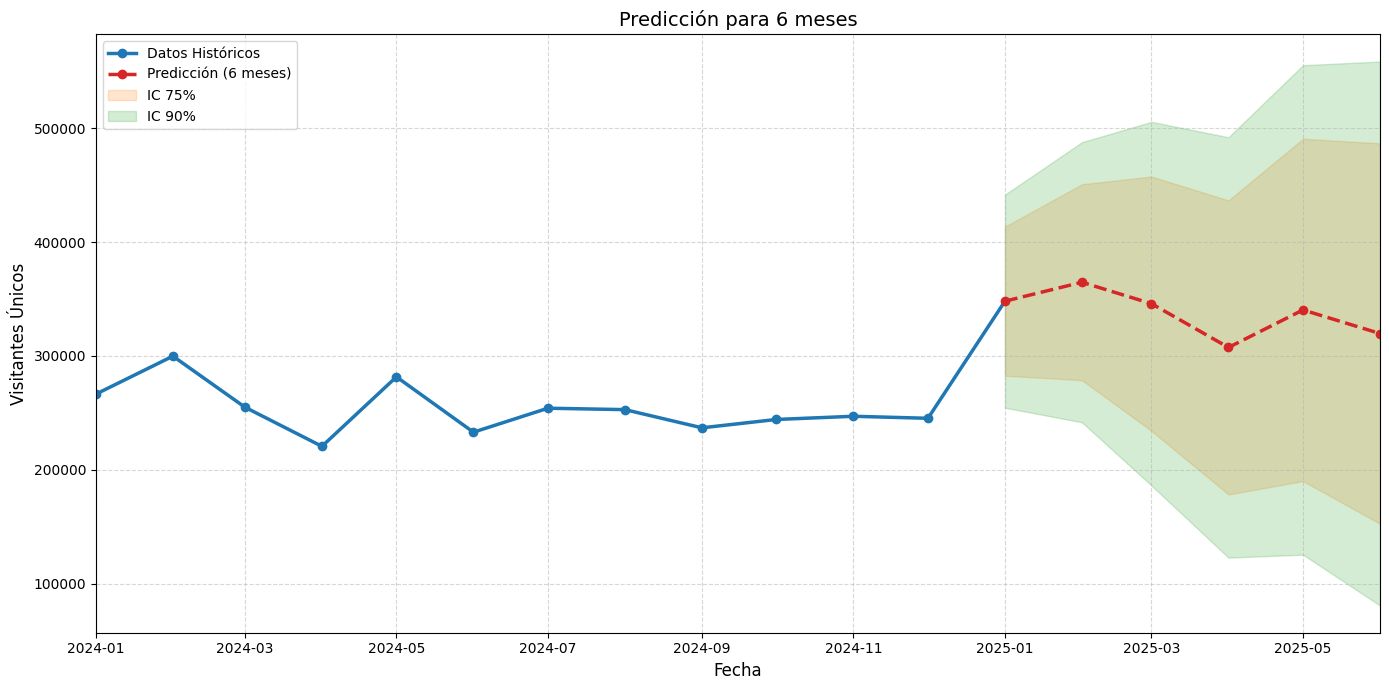


DETALLE DE PREDICCIONES:
     Fecha  Predicción  IC 75% Inferior  IC 75% Superior  IC 90% Inferior  IC 90% Superior
2025-01-01    348174.0         282670.0         413677.0         254512.0         441836.0
2025-02-01    364831.0         278725.0         450937.0         241711.0         487952.0
2025-03-01    345967.0         234158.0         457775.0         186095.0         505838.0
2025-04-01    307524.0         178300.0         436748.0         122750.0         492298.0
2025-05-01    340483.0         190020.0         490946.0         125340.0         555626.0
2025-06-01    319743.0         152534.0         486953.0          80655.0         558832.0


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.api import SARIMAX
import numpy as np

# 1. Ajustar el modelo SARIMA
sarima_model = SARIMAX(df['MMM01_WEB_Unique_visitors'], 
                      order=(1, 2, 2), 
                      seasonal_order=(0, 1, 1, 12))
sarima_fit = sarima_model.fit(disp=False)

# 2. Configurar predicción de 6 meses
forecast_months = 6
last_date = df.index[-1]

# Generar fechas de predicción correctamente alineadas (primer día de cada mes)
prediction_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), 
                                periods=forecast_months, 
                                freq='MS')

# Obtener predicción con intervalos
forecast = sarima_fit.get_forecast(steps=forecast_months)
predictions = pd.Series(forecast.predicted_mean.values, index=prediction_dates)
conf_75 = pd.DataFrame(forecast.conf_int(alpha=0.25).values, 
                      index=prediction_dates, 
                      columns=['lower', 'upper'])
conf_90 = pd.DataFrame(forecast.conf_int(alpha=0.10).values, 
                      index=prediction_dates, 
                      columns=['lower', 'upper'])

# 3. Preparar datos para gráfico (últimos 12 meses históricos)
show_last = 12
historical_data = df['MMM01_WEB_Unique_visitors'].iloc[-show_last:]

# 4. Gráfico con conexión manual en azul
plt.figure(figsize=(14, 7))

# Datos históricos (azul)
plt.plot(historical_data.index, historical_data, 
         label='Datos Históricos', 
         color='#1f77b4', 
         linewidth=2.5,
         marker='o')

# Línea de conexión MANUAL (azul continuo)
plt.plot([historical_data.index[-1], prediction_dates[0]], 
         [historical_data.iloc[-1], predictions.iloc[0]], 
         color='#1f77b4', 
         linewidth=2.5)

# Predicciones (rojo)
plt.plot(predictions.index, predictions, 
         label=f'Predicción ({forecast_months} meses)',
         color='#d62728', 
         linestyle='--', 
         linewidth=2.5,
         marker='o')

# Intervalos de confianza
plt.fill_between(predictions.index, 
                 conf_75['lower'], 
                 conf_75['upper'], 
                 color='#ff7f0e', 
                 alpha=0.2, 
                 label='IC 75%')

plt.fill_between(predictions.index, 
                 conf_90['lower'], 
                 conf_90['upper'], 
                 color='#2ca02c', 
                 alpha=0.2, 
                 label='IC 90%')

# Personalización del gráfico
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Visitantes Únicos', fontsize=12)
plt.title(f'Predicción para {forecast_months} meses', fontsize=14)
plt.legend(fontsize=10, loc='upper left')
plt.grid(True, linestyle='--', alpha=0.5)

# Ajustar límites del eje x
plt.xlim(historical_data.index[0], predictions.index[-1])

plt.tight_layout()
plt.show()

# 5. Tabla de resultados
results_df = pd.DataFrame({
    'Fecha': predictions.index.strftime('%Y-%m-%d'),
    'Predicción': predictions.round(0),
    'IC 75% Inferior': conf_75['lower'].round(0),
    'IC 75% Superior': conf_75['upper'].round(0),
    'IC 90% Inferior': conf_90['lower'].round(0),
    'IC 90% Superior': conf_90['upper'].round(0)
})

print("\nDETALLE DE PREDICCIONES:")
print(results_df.to_string(index=False))